## Image Recognition of Vowels in Sign Language

Machine Learning Individual Project<br>
Asian Institute of Management

Jose Eduardo P. Sto. Domingo<br>
initially finalized 20 August 2018<br>

with edits on March 2022

### Executive Summary (and Write-Up)

<br>

In this notebook, the author attempts to train several classification algorithms to correctly identify the vowel being alluded to by images of hand signs of seven volunteer MS Data Science 2019 students. This project was inspired by one of the MSIB Capstones that involves an attempt to build a communication system for sign language, and the author's general affinity for image processing and using PCA for supervised purposes. Images were taken on 02-03 August 2018 of right hands of classmates using a personal Sony Xperia phone.

Several simplifications were made for this project:<br>
(1) A lot of noise in images was eliminated by using the black side of an illustration board as a background.<br>
(2) Only still images of vowel hand signs were used.<br>
(3) Although certain hand models knew the appropriate hand gestures, images from http://lifeprint.com/asl101/topics/wallpaper1.htm were used to standardize sign language usage.<br>
(4) Lighting was kept consistent using the area near conference room 5 of the 2nd floor of the AIM libary.<br>
(5) Only images of right hands were taken.<br>
(6) No moving frame/image tracker was created to automatically crop a raw image; images were manually centered and cropped as part of pre-processing.<br>
(7) Images captured were already set to be as perpendicular to the bottom axis as much as possible, so the need for rotation was minimized.<br>
(8) The grayscale version of each image was used.<br>
(9) No cross validation set was used to tune parameter values.<br>
(10) Considering the length of time standardization takes for tens of thousands of pixels, `train_test_split` was only performed using one seed, specifically, seed 0.

From an initial image size of 2,204 x 3,920 pixels (about 8.64 million pixels), the author manually cropped a centered image of each hand within a 1300 by 1900 frame (about 2.47 million pixels). Thereafter, he experiment with focusing only on regions within each image that matter -- that is, he did not really need the entire image of the hand to make a differentiation. Looking at the average pixel values by hand sign, it is possible to infer regions where these hand signs differ the most. This means only these regions are really needed. And although this wasn't employed in this notebook, other feature selection/creation methods would involve taking pixel value ratios by regions.

In any case, for this simpler project, the reader is shown results for three different Pixel regions, each used independently in different runs. The table below identifies the coordinates of the "rectangular box" each Region occupied, as well as the number of pixels involved. This is of course based on the 1300 by 1900 grid of pixels. The `Upper` value in this table refers to the vertical top most pixel location at which the rectangle starts. `Lower` on the other hand implies the vertical bottom most pixel location at which the rectangle ends. `Left` denotes the leftmost horizontal pixel location at which the rectangle starts, and `Right` denotes the rightmost pixel location at which the rectangle ends. And although the pixel counts here are in the tens of thousands, note that each set was reduced to Principal Components to retain at least 99% variance.

Table 1. Overall Results


|Region | Upper |Lower |Left|Right|Pixel Count|Top Model and Accuracies|Hyperparameter details|
|--|--|--|--|--|--|--|--|
|Region A | 1250 | 1450 | 350 | 700 | 70 thousand | Decision Tree - 69% Train, 66% Test | Depth: 2 ; Root: -PC 5-|
|Region B | 750 | 1000 | 600 | 800 | 50 thousand | Linear SVM L1 - 100% Train, 77.78% on Test | C value: 2 ;	Strongest Predictor PC: 22|
|Region C| 750 | 1000 | 650 | 850 | 50 thousand |Log Reg L1/L2 and Logistic L1 - 100% Train, 66% Test| various|

<br>

Given that no neural network was used, and given that the PCC x 1.25 threshold for a 5-class identifier is only 25%, the above results are truly truly promising. Moreover, in reality, these pixel regions could be merged together to form a Super non-rectangular group of regions of pixels for ultimate use in a final algorithm. However, this would take an inordinate amount of time to set up, and the author feels such effort is beyond not only the scope of an individual project, but the computing capacity of a personal laptop. Super pixel regions could involve hundreds of thousands of pixels, although arguably with great research, the pixels that truly matter could be identified and isolated.

Furthermore, other feature creation approaches were recommended by Mr. Benjur Emmanuel Borja of the AIM Access Lab, such as Blob analysis, or countour techniques. These are all very promising approaches for future work. Better yet, the pixels strongly projected on the critical Principal Components could be further identified for a potentially more focused solution. Better still, a proper neural network solution could be employed.

By the way, in the final version of this work, the author opted not to fully pursue synthesizing image samples, as suggested by Mr. Johniel Babiera, although such would be perfectly valid for larger scale implementations. Instead, he concentrated efforts on exploring various pixel regions within the original 35 images -- 26 of which became training samples, and 9 became test samples. Still, future work could benefit from taking more image samples from volunteers, or using synthesis, depending on the project intent.

Finally, the author notes with amazement how even non-neural network approaches are able to overfit on the training set -- 100% in some cases. Yes, this was just done on seed 0, so it is quite possible luck was a factor. Still, were this an actual commercial venture, the entrepreneurs could take advantage of simply overfitting on the same hands of users from home. Generalizing for hands outside those seen in the training set could be a later-stage development, as more hand images are collected.

Regardless, below follows a detailed execution of work from 35 original hand images. Pixel Region B above is exclusively used to arrive at sample results at the very bottom, including a confusion matrix, although the reader is given tips on how to use other Pixel regions, or even seeds. Fair warning--depending on the machine used, and the pixel regions used, this notebook could take anywhere from 2-12 minutes to run on one seed.

#### Preliminary Imports

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

import collections as col
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from lmfit import Model
%matplotlib inline
from sklearn.tree import export_graphviz
import graphviz

### Data Familiarization

Our original data essentially are colored photographs that can be imported and interpreted at the pixel level based on pixel values. Below, we show how images can be converted from Colored to Black and White. We do this so as to simplify our pixel values. Notice at this point each image has 8.64 million pixels.

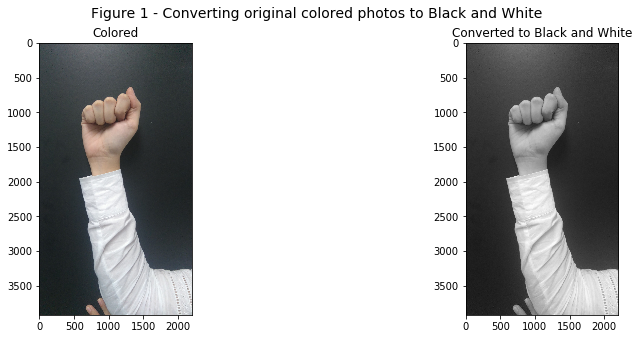

In [ ]:
img = Image.open('originals/sign_A_001.JPG')
img = img.rotate(-90,expand=True)
imggray = img.convert('LA')

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax1.imshow(img)
ax1.set_title('Colored')

ax2.imshow(imggray)
ax2.set_title('Converted to Black and White')

figuretitle = 'Figure 1 - Converting original colored photos to Black and White'
plt.suptitle(figuretitle, size=14);

In [ ]:
img.size

(2204, 3920)

In [ ]:
3920*2204

8639680

Next, we'll need to crop a consistent size of each image that focuses only on the hand.

### Processing task: Crop images to a consistent size. 

Normally, we would create a moving frame algorithm to detect the presence of a hand, and only then activate an algorithm to define. However, for time constraints, we will manually crop each picture. So we are actually skipping a step usually employed by image recognition algorithms.

In any case, we are defaulting our "image size" to be 1300 by 1900 pixels--still a a whopping 2.47 million pixels per image. This means we will still need to be smart about what pixels matter, and creative about grouping certain regions of our images. Given more time, it would also make sense to employ ratios of pixel values by region. Furthermore, we could make use of dimensionality reduction techniques such as Principal Component Analysis.

In [ ]:
def show_cropped_version(path, LEFT, UPPER, width = 1300, height = 1900):
    '''Show cropped version of the picture in the local path.
    
    Parameters:
    -----------
    
    local_path : str
        Path to file.
        
    LEFT : int
        Starting left position of crop box.
        
    UPPER : int
        Starting up position of crop box.
        
    width : int ; optional
        Width of cropped box. Defaulted to 1000
        
    height : int; optional
        Height of cropped box. Defaulted to 1600
        
        
    Returns:
    --------
    
    cropped_imggray : PIL Image object
        cropped image
    
    '''
    img = Image.open(path)
    img = img.rotate(-90,expand=True)
    imggray = img.convert('LA')
    RIGHT = LEFT + width
    LOWER = UPPER + height
    area = (LEFT, UPPER, RIGHT, LOWER)
    cropped_imggray = imggray.crop(area)
    return cropped_imggray

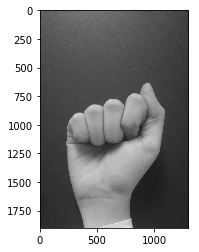

In [ ]:
A001 = show_cropped_version('originals/sign_A_001.JPG',380,0)
plt.imshow(A001);

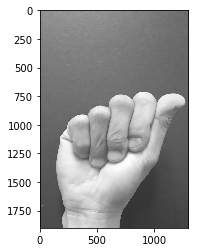

In [ ]:
A002 = show_cropped_version('originals/sign_A_002.JPG',610,150)
plt.imshow(A002);

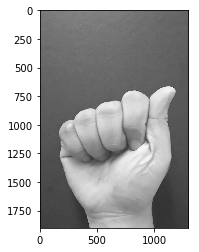

In [ ]:
A003 = show_cropped_version('originals/sign_A_003.JPG',350,400)
plt.imshow(A003);

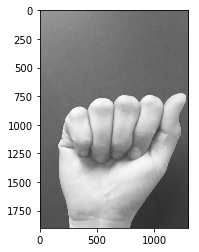

In [ ]:
A004 = show_cropped_version('originals/sign_A_004.JPG',500,50)
plt.imshow(A004);

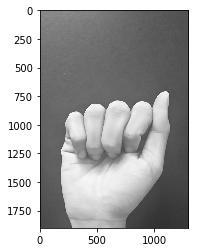

In [ ]:
A005 = show_cropped_version('originals/sign_A_005.JPG',500,180)
plt.imshow(A005);

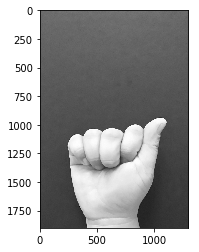

In [ ]:
A006 = show_cropped_version('originals/sign_A_006.JPG',405,470)
plt.imshow(A006);

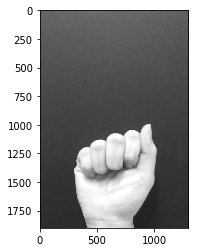

In [ ]:
A007 = show_cropped_version('originals/sign_A_007.JPG',420,490)
plt.imshow(A007);

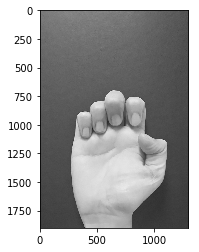

In [ ]:
E001 = show_cropped_version('originals/sign_E_001.JPG',380,120)
plt.imshow(E001);

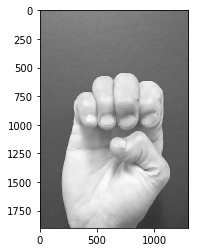

In [ ]:
E002 = show_cropped_version('originals/sign_E_002.JPG',460,400)
plt.imshow(E002);

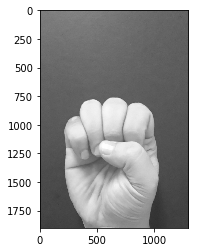

In [ ]:
E003 = show_cropped_version('originals/sign_E_003.JPG',450,450)
plt.imshow(E003);

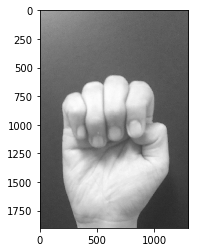

In [ ]:
E004 = show_cropped_version('originals/sign_E_004.JPG',500,400)
plt.imshow(E004);

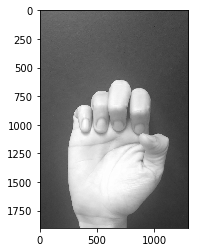

In [ ]:
E005 = show_cropped_version('originals/sign_E_005.JPG',500,400)
plt.imshow(E005);

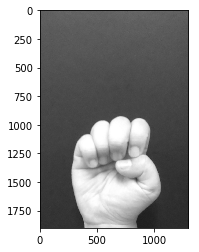

In [ ]:
E006 = show_cropped_version('originals/sign_E_006.JPG',435,530)
plt.imshow(E006);

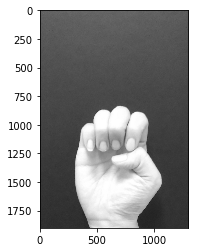

In [ ]:
E007 = show_cropped_version('originals/sign_E_007.JPG',410,500)
plt.imshow(E007);

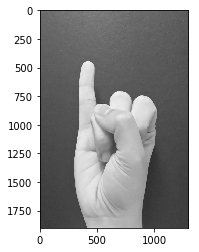

In [ ]:
I001 = show_cropped_version('originals/sign_I_001.JPG',430,450)
plt.imshow(I001);

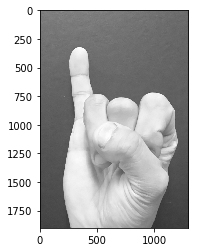

In [ ]:
I002 = show_cropped_version('originals/sign_I_002.JPG',500,550)
plt.imshow(I002);

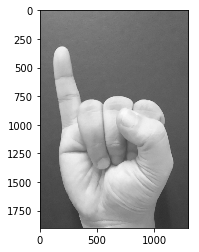

In [ ]:
I003 = show_cropped_version('originals/sign_I_003.JPG',450,450)
plt.imshow(I003);

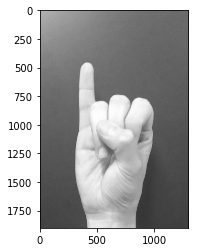

In [ ]:
I004 = show_cropped_version('originals/sign_I_004.JPG',450,300)
plt.imshow(I004);

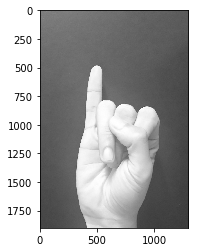

In [ ]:
I005 = show_cropped_version('originals/sign_I_005.JPG',475,500)
plt.imshow(I005);

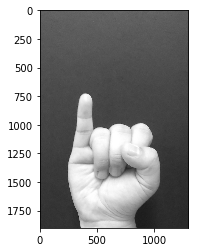

In [ ]:
I006 = show_cropped_version('originals/sign_I_006.JPG',475,610)
plt.imshow(I006);

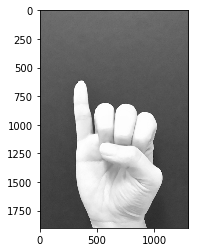

In [ ]:
I007 = show_cropped_version('originals/sign_I_007.JPG',425,700)
plt.imshow(I007);

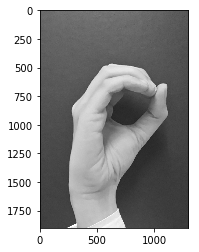

In [ ]:
O001 = show_cropped_version('originals/sign_O_001.JPG',425,300)
plt.imshow(O001);

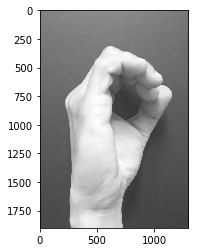

In [ ]:
O002 = show_cropped_version('originals/sign_O_002.JPG',475,550)
plt.imshow(O002);

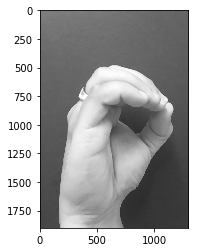

In [ ]:
O003 = show_cropped_version('originals/sign_O_003.JPG',475,600)
plt.imshow(O003);

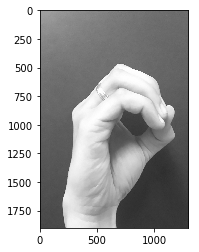

In [ ]:
O004 = show_cropped_version('originals/sign_O_004.JPG',500,450)
plt.imshow(O004);

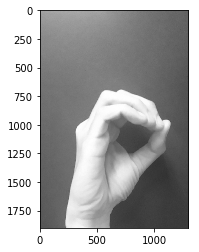

In [ ]:
O005 = show_cropped_version('originals/sign_O_005.JPG',500,250)
plt.imshow(O005);

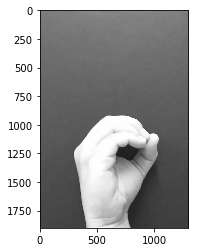

In [ ]:
O006 = show_cropped_version('originals/sign_O_006.JPG',380,420)
plt.imshow(O006);

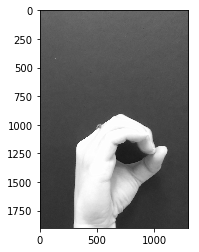

In [ ]:
O007 = show_cropped_version('originals/sign_O_007.JPG',510,530)
plt.imshow(O007);

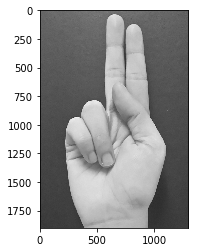

In [ ]:
U001 = show_cropped_version('originals/sign_U_001.JPG',375,325)
plt.imshow(U001);

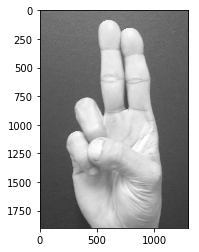

In [ ]:
U002 = show_cropped_version('originals/sign_U_002.JPG',450,525)
plt.imshow(U002);

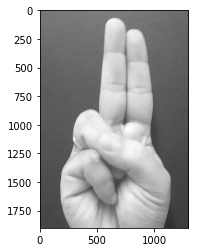

In [ ]:
U003 = show_cropped_version('originals/sign_U_003.JPG',450,525)
plt.imshow(U003);

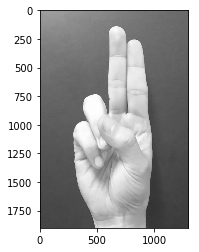

In [ ]:
U004 = show_cropped_version('originals/sign_U_004.JPG',400,525)
plt.imshow(U004);

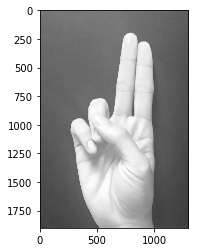

In [ ]:
U005 = show_cropped_version('originals/sign_U_005.JPG',400,650)
plt.imshow(U005);

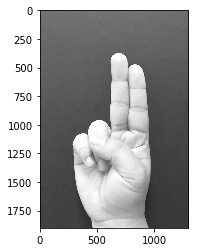

In [ ]:
U006 = show_cropped_version('originals/sign_U_006.JPG',430,650)
plt.imshow(U006);

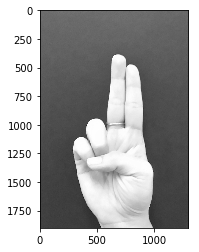

In [ ]:
U007 = show_cropped_version('originals/sign_U_007.JPG',470,720)
plt.imshow(U007);

And there you go. We have now cropped our dataset to a standardized size, at least preliminarily. Next, we'll need to establish some baseline standards.

### Setting Standards: Proportional Chance Criterion

In [ ]:
num_per_vowel = 7

In [ ]:
PCC = 5*(num_per_vowel**2) / (5*7)**2
PCC

0.2

In [ ]:
PCC * 1.25

0.25

For convenience, let us assign the number of samples per vowel (which are all equal) to a variable:

### Feature Selection

Before we proceed to using dimensionality reduction, we can manually reduce the count of pixels we use as features further, by observing the mean pixel values per hand gesture. To get such impressions, we will need to convert our data to numpy array and then eventually numpy matrix format.

#### Conversion to numpy array

In [ ]:
def convert_to_numpy_array(image_object):
    """Return numpy array equivalent of image object.
    
    Parameter(s):
    -------------
    
    image_object : PIL Image object
        Image object.
        
    Returns:
    --------
    
    image_matrix : numpy matrix
        Matrix form of image.
    
    """
    
    temp_mat = np.array(list(image_object.getdata(band=0)), float)
    temp_mat.shape = (image_object.size[1], image_object.size[0])
    image_matrix = np.matrix(temp_mat)
    
    return image_matrix

In [ ]:
A001_mat = convert_to_numpy_array(A001)
A002_mat = convert_to_numpy_array(A002)
A003_mat = convert_to_numpy_array(A003)
A004_mat = convert_to_numpy_array(A004)
A005_mat = convert_to_numpy_array(A005)
A006_mat = convert_to_numpy_array(A006)
A007_mat = convert_to_numpy_array(A007)

E001_mat = convert_to_numpy_array(E001)
E002_mat = convert_to_numpy_array(E002)
E003_mat = convert_to_numpy_array(E003)
E004_mat = convert_to_numpy_array(E004)
E005_mat = convert_to_numpy_array(E005)
E006_mat = convert_to_numpy_array(E006)
E007_mat = convert_to_numpy_array(E007)

I001_mat = convert_to_numpy_array(I001)
I002_mat = convert_to_numpy_array(I002)
I003_mat = convert_to_numpy_array(I003)
I004_mat = convert_to_numpy_array(I004)
I005_mat = convert_to_numpy_array(I005)
I006_mat = convert_to_numpy_array(I006)
I007_mat = convert_to_numpy_array(I007)

O001_mat = convert_to_numpy_array(O001)
O002_mat = convert_to_numpy_array(O002)
O003_mat = convert_to_numpy_array(O003)
O004_mat = convert_to_numpy_array(O004)
O005_mat = convert_to_numpy_array(O005)
O006_mat = convert_to_numpy_array(O006)
O007_mat = convert_to_numpy_array(O007)

U001_mat = convert_to_numpy_array(U001)
U002_mat = convert_to_numpy_array(U002)
U003_mat = convert_to_numpy_array(U003)
U004_mat = convert_to_numpy_array(U004)
U005_mat = convert_to_numpy_array(U005)
U006_mat = convert_to_numpy_array(U006)
U007_mat = convert_to_numpy_array(U007)

And there you go. Our data is in a useful numpy format which we can fiddle with to get features and principal components later on.

#### Representing mean values per pixel

Given our numpy matrix format, we can easily perform matrix operations to arrive at mean pixel values. The visual rendering of these mean matrices are interesting! Psychedelic dude.

In [ ]:
A_mean = (A001_mat+A002_mat+A003_mat+A004_mat+A005_mat+A006_mat+A007_mat)/num_per_vowel
E_mean = (E001_mat+E002_mat+E003_mat+E004_mat+E005_mat+E006_mat+E007_mat)/num_per_vowel
I_mean = (I001_mat+I002_mat+I003_mat+I004_mat+I005_mat+I006_mat+I007_mat)/num_per_vowel
O_mean = (O001_mat+O002_mat+O003_mat+O004_mat+O005_mat+O006_mat+O007_mat)/num_per_vowel
U_mean = (U001_mat+U002_mat+U003_mat+U004_mat+U005_mat+U006_mat+U007_mat)/num_per_vowel

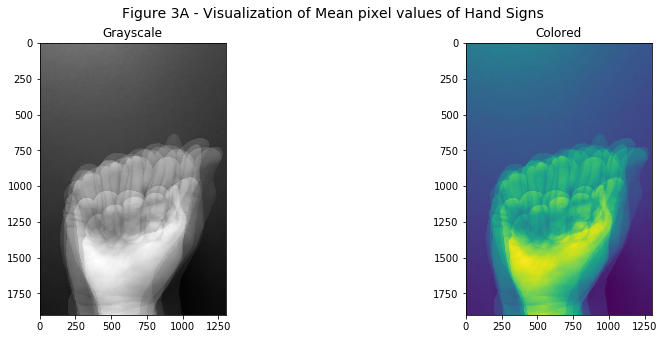

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax1.imshow(A_mean, cmap = 'gray')
ax1.set_title('Grayscale')

ax2.imshow(A_mean)
ax2.set_title('Colored')

figuretitle = 'Figure 3A - Visualization of Mean pixel values of Hand Signs'
plt.suptitle(figuretitle, size=14);

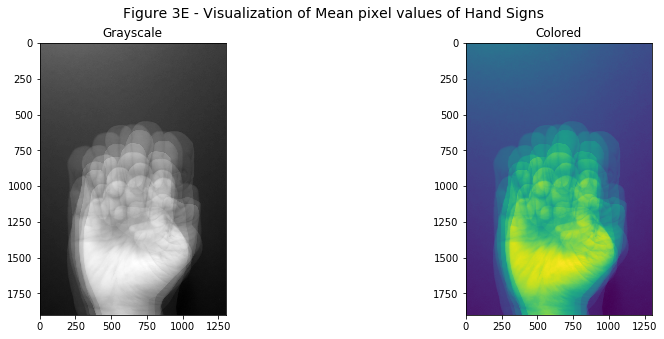

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax1.imshow(E_mean, cmap = 'gray')
ax1.set_title('Grayscale')

ax2.imshow(E_mean)
ax2.set_title('Colored')

figuretitle = 'Figure 3E - Visualization of Mean pixel values of Hand Signs'
plt.suptitle(figuretitle, size=14);

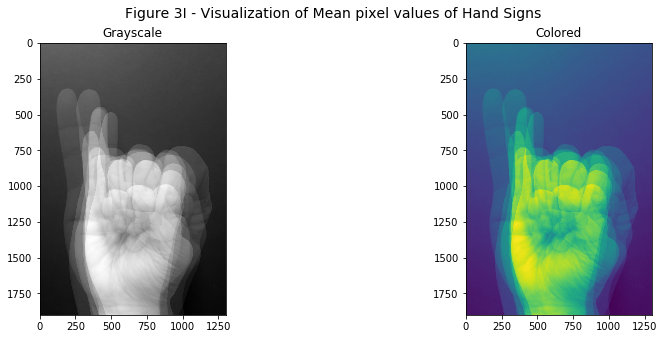

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax1.imshow(I_mean, cmap = 'gray')
ax1.set_title('Grayscale')

ax2.imshow(I_mean)
ax2.set_title('Colored')

figuretitle = 'Figure 3I - Visualization of Mean pixel values of Hand Signs'
plt.suptitle(figuretitle, size=14);

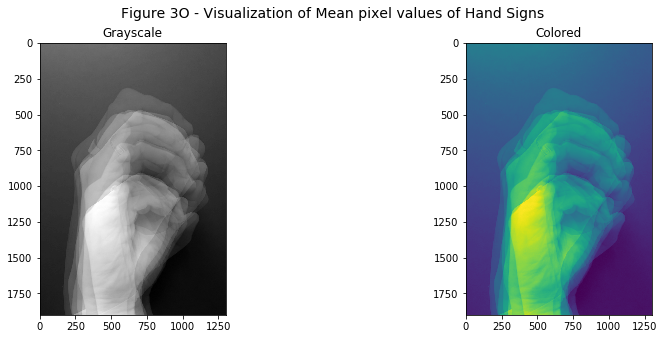

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax1.imshow(O_mean, cmap = 'gray')
ax1.set_title('Grayscale')

ax2.imshow(O_mean)
ax2.set_title('Colored')

figuretitle = 'Figure 3O - Visualization of Mean pixel values of Hand Signs'
plt.suptitle(figuretitle, size=14);

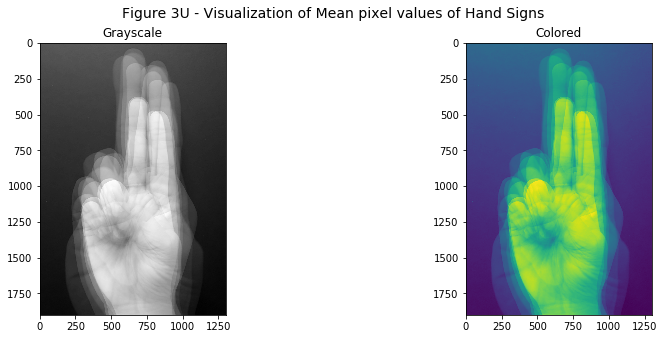

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

ax1.imshow(U_mean, cmap = 'gray')
ax1.set_title('Grayscale')

ax2.imshow(U_mean)
ax2.set_title('Colored')

figuretitle = 'Figure 3U - Visualization of Mean pixel values of Hand Signs'
plt.suptitle(figuretitle, size=14);

We see from the above that we can shave off a lot of pixels that are common to most images--entire regions of each image in fact! We simplify such a step by taking an small rectangular area of our choosing; however, more sophisticated ways to select certain regions are certainly possible.

### Getting Region specific pixel values

We know that our images have the following standardized shape ($m \times n$):

In [ ]:
A001_mat.shape

(1900, 1300)

Therefore, we can take advantage of this grid again to select our regions.

In [ ]:
def region_cropper_mat(matrix_object, upper, lower, left, right):
    '''Return specific rectangular area of numpy matrix.

    Parameters:
    -----------

    matrix_object : numpy matrix
        Numpy matrix object, presumably of an image in grayscale.


    Returns:
    --------

    sub_matrix : numpy matrix
        Numpy matrix object, cropped to selected points

    '''

    sub_matrix = matrix_object[upper:lower, left:right]
    
    return sub_matrix

In [ ]:
def averager_by_region(list_of_matrices, lower, right, upper, left):
    '''compute mean pixel values for a given set of matrices.
    
    Parameters:
    -----------
    
    list_of_matrices: list of numpy matrices
        List of matrices from which to check pixel values by region.
        
    lower : int
        Lower boundary of crop box.
        
    right : int
        Right-hand boundary of crop box.
        
    upper : int
        Upper boundary of crop box.
        
    left : int
        Left-hand boundary of crop box.
        
    Returns:
    --------
    
    mean_matrix : numpy matrix
        Numpy matrix of mean pixel values.
    
    '''
    
    zeroes_np = np.zeros((lower-upper)*(right-left))
    zeroes_np.shape = ((lower-upper), (right-left))
    zeroes_mat = np.matrix(zeroes_np)
    
    for i in list_of_matrices:
        z = i[:,:]
        temp = region_cropper_mat(z,upper,lower,left,right)
        zeroes_mat += temp
    
    mean_matrix = zeroes_mat / num_per_vowel
    
    return mean_matrix

In [ ]:
set_A = [A001_mat, A002_mat, A003_mat, A004_mat, A005_mat, A006_mat, A007_mat]
set_E = [E001_mat, E002_mat, E003_mat, E004_mat, E005_mat, E006_mat, E007_mat]
set_I = [I001_mat, I002_mat, I003_mat, I004_mat, I005_mat, I006_mat, I007_mat]
set_O = [O001_mat, O002_mat, O003_mat, O004_mat, O005_mat, O006_mat, O007_mat]
set_U = [U001_mat, U002_mat, U003_mat, U004_mat, U005_mat, U006_mat, U007_mat]

### Preview of mean values of selected regions

Given that our helper functions are all set up, we can get a quick preview of the mean pixel values of the Region we chose. The user is free to select coordinates, or simply uncomment the other coordinate settings already set here to see how results at the end are affected.

Total Pixels: 50000


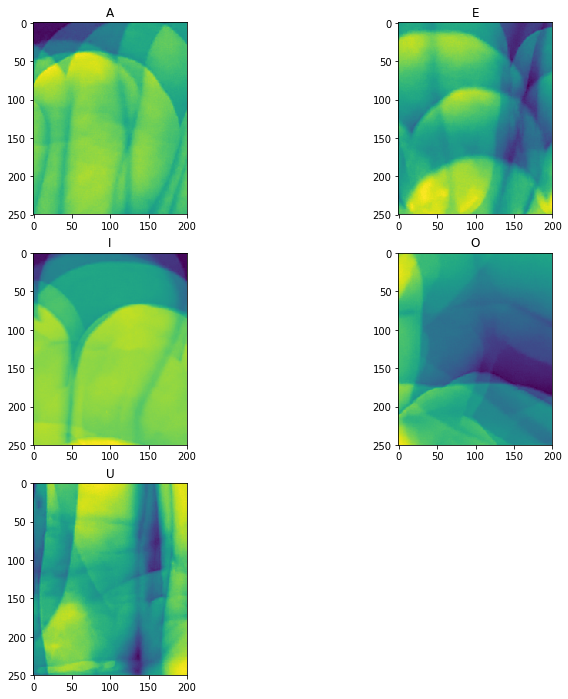

In [ ]:
# REGION A
# Decision Tree 66% on Test:
# upper = 1250
# lower = 1450
# left = 350
# right = 700

# REGION B
# Linear SVM L1 77.78% on Test
upper = 750
lower = 1000
left = 600
right = 800

# REGION C
# 66 % on most linear/ log
# upper = 750
# lower = 1000
# left = 650
# right = 850

fig = plt.figure(figsize = (12,12))

ex_plot1 = fig.add_subplot(3,2,1)
ex_plot2 = fig.add_subplot(3,2,2)
ex_plot3 = fig.add_subplot(3,2,3)
ex_plot4 = fig.add_subplot(3,2,4)
ex_plot5 = fig.add_subplot(3,2,5)

ex_plot1.imshow(averager_by_region(set_A, lower, right, upper, left))
ex_plot2.imshow(averager_by_region(set_E, lower, right, upper, left))
ex_plot3.imshow(averager_by_region(set_I, lower, right, upper, left))
ex_plot4.imshow(averager_by_region(set_O, lower, right, upper, left))
ex_plot5.imshow(averager_by_region(set_U, lower, right, upper, left))

ex_plot1.set_title("A")
ex_plot2.set_title("E")
ex_plot3.set_title("I")
ex_plot4.set_title("O")
ex_plot5.set_title("U");

print("Total Pixels:",((lower-upper)*(right-left)))

### Isolate relevant regions for each picture

Now that we have decided on which region to work with, let's directly crop the smaller figure for our use.

In [ ]:
def cropper_by_region(list_of_matrices, lower, right, upper, left):
    '''Gather pixels only in selected region.
    
    Parameters:
    -----------
    
    list_of_matrices: list of numpy matrices
        List of matrices from which to check pixel values by region.
        
    lower : int
        Lower boundary of crop box.
        
    right : int
        Right-hand boundary of crop box.
        
    upper : int
        Upper boundary of crop box.
        
    left : int
        Left-hand boundary of crop box.
        
    Returns:
    --------
    
    new_list_of_matrices : list of matrices
        List of numpy matrices of cropped features.
    
    '''
    
    new_list_of_matrices = []
    for i in list_of_matrices:
        z = i[:,:]
        temp = region_cropper_mat(z,upper,lower,left,right)
        new_list_of_matrices.append(temp)
    
    return new_list_of_matrices

In [ ]:
# Note: lower, right, upper, left, set above
new_set_A = cropper_by_region(set_A,lower, right, upper, left)
new_set_E = cropper_by_region(set_E,lower, right, upper, left)
new_set_I = cropper_by_region(set_I,lower, right, upper, left)
new_set_O = cropper_by_region(set_O,lower, right, upper, left)
new_set_U = cropper_by_region(set_U,lower, right, upper, left)

### Transforming to a Pandas DataFrame

For easier conceptualization, we unroll our pixel values into a pandas DataFrame called `df_PIXELS`, and add a target column. We also create a DataFrame `x_df_pre_pca` with no `Target` column.

In [ ]:
target = []
for i in ['A','E','I','O','U']:
    target += [i for p in range(num_per_vowel)]

df_PIXELS = pd.DataFrame(
    columns=[i for i in range((lower-upper)*(right-left))])

for i in new_set_A:
    if np.isnan(df_PIXELS.index.max()):
        df_PIXELS.loc[0] = [p for p in np.array(i).ravel()]
    else:
        df_PIXELS.loc[df_PIXELS.index.max(
        )+1] = [p for p in np.array(i).ravel()]

for i in new_set_E:
    if np.isnan(df_PIXELS.index.max()):
        df_PIXELS.loc[0] = [p for p in np.array(i).ravel()]
    else:
        df_PIXELS.loc[df_PIXELS.index.max(
        )+1] = [p for p in np.array(i).ravel()]

for i in new_set_I:
    if np.isnan(df_PIXELS.index.max()):
        df_PIXELS.loc[0] = [p for p in np.array(i).ravel()]
    else:
        df_PIXELS.loc[df_PIXELS.index.max(
        )+1] = [p for p in np.array(i).ravel()]

for i in new_set_O:
    if np.isnan(df_PIXELS.index.max()):
        df_PIXELS.loc[0] = [p for p in np.array(i).ravel()]
    else:
        df_PIXELS.loc[df_PIXELS.index.max(
        )+1] = [p for p in np.array(i).ravel()]

for i in new_set_U:
    if np.isnan(df_PIXELS.index.max()):
        df_PIXELS.loc[0] = [p for p in np.array(i).ravel()]
    else:
        df_PIXELS.loc[df_PIXELS.index.max(
        )+1] = [p for p in np.array(i).ravel()]


df_PIXELS['Target'] = target

target_mapping = {
'A': 0,
'E': 1,
'I': 2,
'O': 3,
'U': 4}
df_PIXELS['Target'] = df_PIXELS['Target'].map(target_mapping)

x_df_pre_pca = df_PIXELS.drop('Target', axis = 1)

## Perform dimensionality reduction

From here on the next step is to perform a dimensionality reduction technique. We'll go with Principal Component Analysis (PCA), which would essentially project our original values onto fewer representative dimensions or components.

However, PCA would work better if our training features are standardized. We address this and other needs next.

### Manual Train Test Split and manual Standardization Code

Manual segregation of our training and test sets is necessary, since, according to Professor Andrew Ng of Stanford, only the PCs of the training set should be computed. Later on, test values can be converted onto corresponding PC values manually. Although `train_test_split` already does a decent job, the author finds it easier to perform targeted PCA and standardization with a custom code.

In any case, one way to randomize rows is to generate a random set of values equal to the number of our original rows, and then use argsort to return the index values arranged by order. (This is an approach first learned by the author from Professor Ng's ML MOOC.)

We create the helper function `manual_split` below to give us a list of lists of indices. Thereafter, the function `vals` returns nominal, scaled, or standardized values of our features. Principal Component Analysis is then applied separately.

In [ ]:
def manual_split(df_general, rstate = 0, tsize = 0.25):
    '''Split indices of DataFrame into train and test samples.
    
    Parameters
    ----------
    
    df_general : DataFrame
        Dataframe containing feature values.
        
    r_state : int, optional
        Seed to use for random bifurcation between train and test sets.
        Defaulted to zero.
        
    tsize : float, optional
        Portion of overall samples to use as test set.
        Defaulted to 25%.
    
    
    Returns
    -------
    
    list of lists containing indices
    '''

    x_dummy = [i for i in range(len(df_general))]
    y_dummy = [i for i in range(len(df_general))]

    X_tr_rows, X_ts_rows, y_tr_rows, y_ts_rows = train_test_split(
        x_dummy, y_dummy, test_size=tsize, random_state=rstate)

    return [X_tr_rows, X_ts_rows, y_tr_rows, y_ts_rows]

In [ ]:
def vals(df_general, df_main, target_col, r_state=0, scaler=0):
    """Return train and test values based on seed generated.

    Parameters
    ----------

    df_general : DataFrame
        Dataframe containing predictive feature values.

    df_main : DataFrame
        Original DataFrame containing all feature values.

    target_col : str
        Target column

    r_state : int, optional
        Seed to use for random bifurcation between train and test sets.
        Defaulted to zero.

    scaler : int, optional
        Indicates further standardization or scaling of values.
        Defaulted to 0.
        If 1, apply min max scaling using training set.
        If 2, apply standardization using training set.

    Returns
    -------

    list of numpy arrays
        Training and test x and y values.

    """

    indx = manual_split(df_general, r_state)

    x_df_train = df_general.iloc[indx[0], :]
    x_df_test = df_general.iloc[indx[1], :]

    # minmax values
    if scaler is 1:
        
        x_df_train_minmax = pd.DataFrame()
        for i in x_df_train.columns:
            xmin = x_df_train[i].min()
            xmax = x_df_train[i].max()
            x_df_train_minmax[i] = (x_df_train[i] - xmin)/(xmax-xmin)

        x_df_test_minmax = pd.DataFrame()
        for i in x_df_test.columns:
            xmin = x_df_train[i].min()
            xmax = x_df_train[i].max()
            x_df_test_minmax[i] = (x_df_test[i] - xmin)/(xmax-xmin)

        x_np_train = x_df_train_minmax.values
        x_np_test = x_df_test_minmax.values

    # standardized values
    if scaler is 2:
        
        x_df_train_standard = pd.DataFrame()
        for i in x_df_train.columns:
            xmean = x_df_train[i].mean()
            xstd = x_df_train[i].std()            
            x_df_train_standard[i] = (x_df_train[i] - xmean)/(xstd)

        x_df_test_standard = pd.DataFrame()
        for i in x_df_test.columns:
            xmean = x_df_train[i].mean()
            xstd = x_df_train[i].std()            
            x_df_test_standard[i] = (x_df_test[i] - xmean)/(xstd)

        x_np_train = x_df_train_standard.values
        x_np_test = x_df_test_standard.values

    if scaler is 0:
        x_np_train = x_df_train.values
        x_np_test = x_df_test.values

    y_df_train = df_main.iloc[indx[2], :]
    y_df_train = y_df_train[target_col]
    y_np_train = np.array(list(y_df_train.values))

    y_df_test = df_main.iloc[indx[3], :]
    y_df_test = y_df_test[target_col]
    y_np_test = np.array(list(y_df_test.values))

    return [x_np_train, x_np_test, y_np_train, y_np_test]

Note to user: In the following cell, you may change `r_state` to experiment on using a different seed.

In [ ]:
x_np_train, x_np_test, y_np_train, y_np_test = vals(
    x_df_pre_pca, df_PIXELS, 'Target', r_state=0, scaler=2)

### Observe variance explained and minimum number of features to retain 99 variance%

In [ ]:
x_pca = PCA()
x_pca.fit(x_np_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

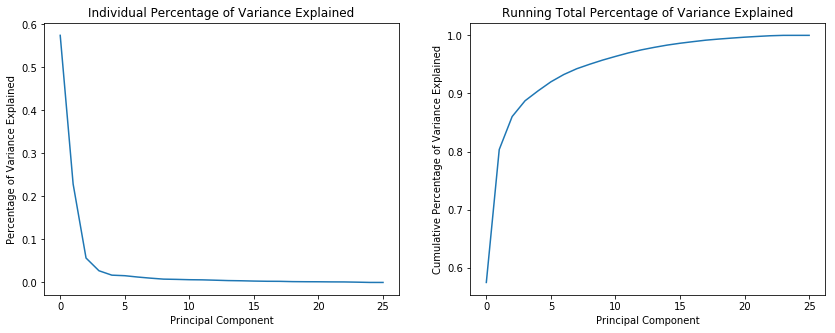

In [ ]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize = (14,5))

ax1.plot(x_pca.explained_variance_ratio_)
ax1.set_ylabel('Percentage of Variance Explained')
ax1.set_xlabel('Principal Component')
ax1.set_title('Individual Percentage of Variance Explained');

ax2.plot(x_pca.explained_variance_ratio_.cumsum())
ax2.set_ylabel('Cumulative Percentage of Variance Explained')
ax2.set_xlabel('Principal Component')
ax2.set_title('Running Total Percentage of Variance Explained');

> By eyeballing the second graphic above, one can cut down features by selecting a number of PCs, and still retain at least 99% of variance. Below are some options.

In [ ]:
PC_summary = pd.DataFrame([(i+1,x_pca.explained_variance_ratio_.cumsum()[i]) for i in range(15,25)])
PC_summary.rename(columns={0 : 'PC'}, inplace=True)
PC_summary.rename(columns={1 : 'Cumulative Percentage of Variance Explained'}, inplace=True)
display(PC_summary)

,PC,Cumulative Percentage of Variance Explained
0,16,0.986409
1,17,0.989133
2,18,0.991710
3,19,0.993621
4,20,0.995296
5,21,0.996859
6,22,0.998152
7,23,0.999327
8,24,0.999977
9,25,1.000000


It is now possible to approximate results as if ALL features were used, with significantly less computing power needed! :)

In [ ]:
n_components = 25
U_reducePCs = x_pca.components_[0:n_components]
U_reducePCs.shape

(25, 50000)

> All right, so the `U_reducePCs` matrix is already in $k \times n$ format. It *should* be possible to multiply that now with the training features. `U_reducePCs` contains just the chosen Principal Components that can be multiplied to the normalized and scaled features to arrive at a smaller set of features that represent the variance of the original features.

In [ ]:
np.transpose(x_np_train).shape

(50000, 26)

In [ ]:
x_np_PCs_train = np.transpose(
    np.matmul(U_reducePCs, np.transpose(x_np_train)))
x_np_PCs_train.shape

(26, 25)

In [ ]:
x_np_PCs_test = np.transpose(
    np.matmul(U_reducePCs, np.transpose(x_np_test)))
x_np_PCs_test.shape

(9, 25)

In [ ]:
x_df_PCs_train = pd.DataFrame(x_np_PCs_train)
x_df_PCs_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,137.236003,-199.075842,-78.764592,-17.223028,-5.012949,12.620661,-0.648790,-10.395644,17.758815,-7.340853,...,-3.997879,14.388042,6.715874,-6.318758,-9.037122,-6.759627,6.063708,2.488729,0.114581,-0.006400
1,-152.164040,174.972278,50.870216,30.049895,17.815753,-15.306230,-1.395858,10.953895,-5.382471,-13.341315,...,-23.433356,22.584458,8.536910,0.907899,-14.574710,-9.821998,15.679778,-0.001184,1.249715,-0.149894
2,-214.503160,53.045643,-12.574424,-18.937842,28.124329,-5.209408,-22.590834,-0.364279,10.622422,20.414245,...,7.700293,17.086150,31.440450,1.692731,4.557555,18.432013,-12.240988,1.839849,-3.920170,-0.056232
3,-132.175689,-57.610509,-54.562433,92.835385,-14.598773,-35.120953,4.618691,-31.236630,-13.373324,28.264456,...,-13.028399,-17.962555,1.480528,10.034055,-4.791307,0.536568,-8.219097,-2.221914,3.629163,0.040680
4,82.240470,-177.699174,-76.856804,-28.671575,17.215740,-1.980881,15.450483,-18.459676,15.613132,-22.956253,...,-18.219984,-0.329757,-1.301601,5.126788,7.000795,2.723437,3.487947,-3.086596,1.139584,-0.027867


Annnnnd there you have it. There are now fewer features that represent 99% of the variance of all thousands of original features. Let's see how the first three PCs graph against each other.

In [ ]:
train_PCs_andY = pd.DataFrame()
train_PCs_andY['1stPC'] = x_df_PCs_train[0]
train_PCs_andY['2ndPC'] = x_df_PCs_train[1]
train_PCs_andY['3rdPC'] = x_df_PCs_train[2]
train_PCs_andY['Target'] = y_np_train

In [ ]:
df_A = pd.DataFrame()
df_E = pd.DataFrame()
df_I = pd.DataFrame()
df_O = pd.DataFrame()
df_U = pd.DataFrame()

df_A = train_PCs_andY[train_PCs_andY.Target == 0]
df_E = train_PCs_andY[train_PCs_andY.Target == 1]
df_I = train_PCs_andY[train_PCs_andY.Target == 2]
df_O = train_PCs_andY[train_PCs_andY.Target == 3]
df_U = train_PCs_andY[train_PCs_andY.Target == 4]

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


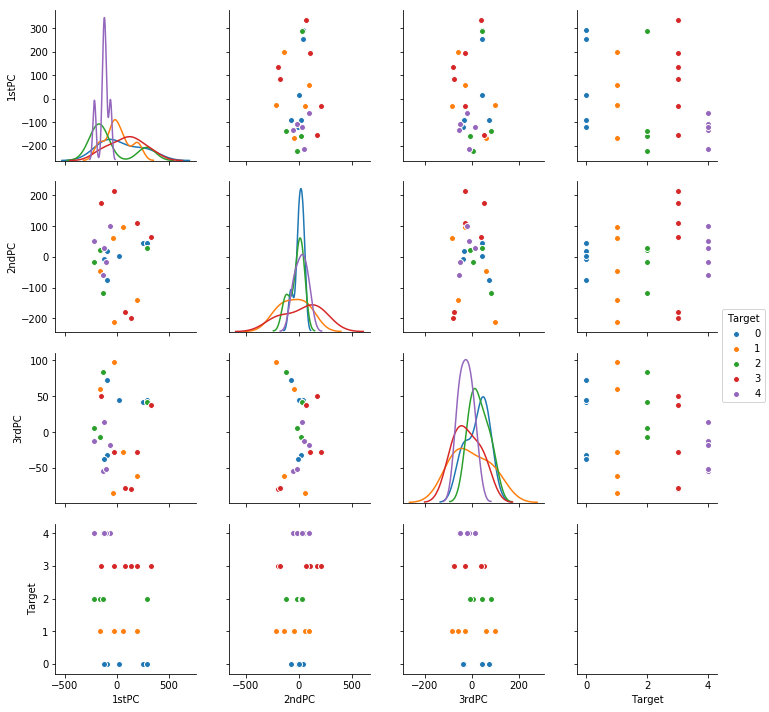

In [ ]:
sns.pairplot(train_PCs_andY,hue='Target',diag_kind='kde');

Based on the kde plots, we see some promising results based on the region of pixels we chose.

## Execution of Algorithms

Next, we'll have to define some of our base functions by algorithm. To save time, we'll just use the results of one seed, since standardization on tens of thousands of pixels takes quite a while per iteration. We create a helper function that will help run all these algorithms and spit out a summary in the end.

In [ ]:
def knn_classification_simple(X_train, X_test, y_train, y_test):
    """Compute train and test accuracies and nearest neighbor hyperparameters.

    Parameters
    ----------

    X_train : numpy array of floats
        Contains new training feature values based on standardization and PCA.
    
    X_test : numpy array of floats
        Contains new test feature values as adjusted on train set for
        standardization and PCA.
    
    y_train : numpy array of floats
        Contains y training target values.
    
    y_test : numpy array of floats
        Contains y test target values.

    Returns
    -------

    list of floats and int
        Highest mean test accuracy, applicable neighbor, and
        mean training accuracy at this setting.

    """
    All_training = pd.DataFrame()
    All_test = pd.DataFrame()

    training_accuracy = []
    test_accuracy = []
    neighbors_settings = range(1, 20)

    for n_neighbors in neighbors_settings:
        reg = KNeighborsClassifier(n_neighbors=n_neighbors)
        reg.fit(X_train, y_train)
        # record training set accuracy
        training_accuracy.append(reg.score(X_train, y_train))
        # record generalization accuracy
        test_accuracy.append(reg.score(X_test, y_test))
    All_training[0] = training_accuracy
    All_test[0] = test_accuracy

    tst_acc_highest = ((All_test.mean(axis=1)).max()*100)
    tst_neighbors = np.argmax([All_test.mean(axis=1)])+1
    trn_acc_at_test_highest = (
        (All_training.mean(axis=1))[tst_neighbors-1])*100

    return [tst_acc_highest, tst_neighbors, trn_acc_at_test_highest]

In [ ]:
def logisticL2_classification_simple(X_train, X_test, y_train, y_test):
    """Compute train and test accuracies, c and best feature hyperparameters.

    Parameters
    ----------

    X_train : numpy array of floats
        Contains new training feature values based on standardization and PCA.

    X_test : numpy array of floats
        Contains new test feature values as adjusted on train set for
        standardization and PCA.

    y_train : numpy array of floats
        Contains y training target values.

    y_test : numpy array of floats
        Contains y test target values.

    Returns
    -------

    list of floats and int
        Highest mean test accuracy, applicable c value, best feature, and
        mean training accuracy at this setting.

    """
    All_training = pd.DataFrame()
    All_test = pd.DataFrame()

    c_vals = [0.001, 0.01, 0.05, 0.1, 0.15, 1, 1.01, 1.1, 1.25, 2, 3, 4, 5,
              6, 7, 8, 9, 10, 30, 35, 40, 50]

    training_accuracy = []
    test_accuracy = []
    tr_coeffs = []

    for c_val in c_vals:
        log_reg = LogisticRegression(C=c_val).fit(X_train, y_train)
        # record training set accuracy
        training_accuracy.append(log_reg.score(X_train, y_train))
        # record generalization accuracy
        test_accuracy.append(log_reg.score(X_test, y_test))

    All_training[0] = training_accuracy
    All_test[0] = test_accuracy

    tst_acc_highest = ((All_test.mean(axis=1)).max()*100)
    tst_indx = np.argmax([All_test.mean(axis=1)])
    trn_acc_at_test_highest = ((All_training.mean(axis=1))[tst_indx])*100
    tst_best_c = c_vals[tst_indx]

    tr_coeffs = []

    log_reg = LogisticRegression(C=tst_best_c).fit(X_train, y_train)
    tr_coeffs.append(log_reg.coef_.tolist()[0])

    max_coef = pd.DataFrame(tr_coeffs).mean().abs().max()
    max_coef_col_indx = np.argmax(pd.DataFrame(tr_coeffs).mean().abs().values)
    max_coef_col = x_df_PCs_train.columns[max_coef_col_indx]

    return [tst_acc_highest, tst_indx, trn_acc_at_test_highest, tst_best_c, max_coef, max_coef_col]

In [ ]:
def logisticL1_classification_simple(X_train, X_test, y_train, y_test):
    """Compute train and test accuracies, c and best feature hyperparameters.

    Parameters
    ----------

    X_train : numpy array of floats
        Contains new training feature values based on standardization and PCA.

    X_test : numpy array of floats
        Contains new test feature values as adjusted on train set for
        standardization and PCA.

    y_train : numpy array of floats
        Contains y training target values.

    y_test : numpy array of floats
        Contains y test target values.

    Returns
    -------

    list of floats and int
        Highest mean test accuracy, applicable c value, best feature, and
        mean training accuracy at this setting.

    """
    All_training = pd.DataFrame()
    All_test = pd.DataFrame()
    
    c_vals = [0.001, 0.01, 0.05, 0.1, 0.15, 1, 1.01, 1.1, 1.25, 2, 3, 4, 5,
              6, 7, 8, 9, 10, 30, 35, 40,50]

    training_accuracy = []
    test_accuracy = []
    tr_coeffs = []

    for c_val in c_vals:
        log_reg = LogisticRegression(C=c_val, penalty="l1").fit(X_train, y_train)
        # record training set accuracy
        training_accuracy.append(log_reg.score(X_train, y_train))
        # record generalization accuracy
        test_accuracy.append(log_reg.score(X_test, y_test))

    All_training[0] = training_accuracy
    All_test[0] = test_accuracy

    tst_acc_highest = ((All_test.mean(axis=1)).max()*100)
    tst_indx = np.argmax([All_test.mean(axis=1)])
    trn_acc_at_test_highest = ((All_training.mean(axis=1))[tst_indx])*100
    tst_best_c = c_vals[tst_indx]
    
    tr_coeffs = []

    log_reg = LogisticRegression(C=tst_best_c, penalty="l1").fit(X_train, y_train)
    tr_coeffs.append(log_reg.coef_.tolist()[0])

    max_coef = pd.DataFrame(tr_coeffs).mean().abs().max()
    max_coef_col_indx = np.argmax(pd.DataFrame(tr_coeffs).mean().abs().values)
    max_coef_col = x_df_PCs_train.columns[max_coef_col_indx]

    return [tst_acc_highest, tst_indx, trn_acc_at_test_highest, tst_best_c, max_coef, max_coef_col]

In [ ]:
def svmL2_classification_simple(X_train, X_test, y_train, y_test):
    """Compute train and test accuracies, c and best feature hyperparameters.

    Parameters
    ----------

    X_train : numpy array of floats
        Contains new training feature values based on standardization and PCA.

    X_test : numpy array of floats
        Contains new test feature values as adjusted on train set for
        standardization and PCA.

    y_train : numpy array of floats
        Contains y training target values.

    y_test : numpy array of floats
        Contains y test target values.

    Returns
    -------

    list of floats and int
        Highest mean test accuracy, applicable c value, best feature, and
        mean training accuracy at this setting.

    """
    All_training = pd.DataFrame()
    All_test = pd.DataFrame()
    
    c_vals = [0.001, 0.01, .1, 1, 2, 5, 10, 15, 20, 40]

    training_accuracy = []
    test_accuracy = []
    tr_coeffs = []

    for c_val in c_vals:
        svm = LinearSVC(C=c_val, penalty="l2").fit(X_train, y_train)
        # record training set accuracy
        training_accuracy.append(svm.score(X_train, y_train))
        # record generalization accuracy
        test_accuracy.append(svm.score(X_test, y_test))

    All_training[0] = training_accuracy
    All_test[0] = test_accuracy

    tst_acc_highest = ((All_test.mean(axis=1)).max()*100)
    tst_indx = np.argmax([All_test.mean(axis=1)])
    trn_acc_at_test_highest = ((All_training.mean(axis=1))[tst_indx])*100
    tst_best_c = c_vals[tst_indx]
    
    tr_coeffs = []

    svm = LinearSVC(C=c_val, penalty="l2").fit(X_train, y_train)
    tr_coeffs.append(svm.coef_.tolist()[0])

    max_coef = pd.DataFrame(tr_coeffs).mean().abs().max()
    max_coef_col_indx = np.argmax(pd.DataFrame(tr_coeffs).mean().abs().values)
    max_coef_col = x_df_PCs_train.columns[max_coef_col_indx]

    return [tst_acc_highest, tst_indx, trn_acc_at_test_highest, tst_best_c, max_coef, max_coef_col]

In [ ]:
def svmL1_classification_simple(X_train, X_test, y_train, y_test):
    """Compute train and test accuracies, c and best feature hyperparameters.

    Parameters
    ----------

    X_train : numpy array of floats
        Contains new training feature values based on standardization and PCA.

    X_test : numpy array of floats
        Contains new test feature values as adjusted on train set for
        standardization and PCA.

    y_train : numpy array of floats
        Contains y training target values.

    y_test : numpy array of floats
        Contains y test target values.

    Returns
    -------

    list of floats and int
        Highest mean test accuracy, applicable c value, best feature, and
        mean training accuracy at this setting.

    """
    All_training = pd.DataFrame()
    All_test = pd.DataFrame()

    c_vals = [0.001, 0.01, 1, 2, 3, 4, 5, 10, 50, 200]

    training_accuracy = []
    test_accuracy = []
    tr_coeffs = []

    for c_val in c_vals:
        svm = LinearSVC(C=c_val, penalty="l1",
                        dual=False).fit(X_train, y_train)
        # record training set accuracy
        training_accuracy.append(svm.score(X_train, y_train))
        # record generalization accuracy
        test_accuracy.append(svm.score(X_test, y_test))

    All_training[0] = training_accuracy
    All_test[0] = test_accuracy

    tst_acc_highest = ((All_test.mean(axis=1)).max()*100)
    tst_indx = np.argmax([All_test.mean(axis=1)])
    trn_acc_at_test_highest = ((All_training.mean(axis=1))[tst_indx])*100
    tst_best_c = c_vals[tst_indx]

    tr_coeffs = []

    svm = LinearSVC(C=c_val, penalty="l1", dual=False).fit(X_train, y_train)
    tr_coeffs.append(svm.coef_.tolist()[0])

    max_coef = pd.DataFrame(tr_coeffs).mean().abs().max()
    max_coef_col_indx = np.argmax(pd.DataFrame(tr_coeffs).mean().abs().values)
    max_coef_col = x_df_PCs_train.columns[max_coef_col_indx]

    return [tst_acc_highest, tst_indx, trn_acc_at_test_highest, tst_best_c, max_coef, max_coef_col]

In [ ]:
def svmRBF_classification_simple(X_train, X_test, y_train, y_test, c_val):
    """Compute accuracies using RBF and relevant hyperparameters.
    
    Parameters
    ----------
    
    X_train : numpy array of floats
        Contains new training feature values based on standardization and PCA.

    X_test : numpy array of floats
        Contains new test feature values as adjusted on train set for
        standardization and PCA.

    y_train : numpy array of floats
        Contains y training target values.

    y_test : numpy array of floats
        Contains y test target values.
        
    c_val : float
        Hyperparameter.
    
    Returns
    -------

    list of floats
        Highest mean test accuracy, best g value, and
        mean training accuracy at this setting.

    """
    All_training = pd.DataFrame()
    All_test = pd.DataFrame()

    g_vals = [0.001, 0.01, 0.1, .5, 1, 2, 5, 10, 40]

    training_accuracy = []
    test_accuracy = []

    for g_val in g_vals:
        svm_rbf = SVC(kernel='rbf', random_state=10, gamma=g_val, C=c_val)
        svm_rbf.fit(X_train, y_train)
        # record training set accuracy
        training_accuracy.append(svm_rbf.score(X_train, y_train))
        # record generalization accuracy
        test_accuracy.append(svm_rbf.score(X_test, y_test))

    All_training[0] = training_accuracy
    All_test[0] = test_accuracy

    tst_acc_highest = ((All_test.mean(axis=1)).max()*100)
    tst_indx = np.argmax([All_test.mean(axis=1)])
    trn_acc_at_test_highest = ((All_training.mean(axis=1))[tst_indx])*100
    tst_best_g = g_vals[tst_indx]

    return [tst_acc_highest, tst_best_g, trn_acc_at_test_highest]

In [ ]:
def dectree_classification_simple(X_train, X_test, y_train, y_test):
    """Compute accuracies with Decision Tree Regressor and hyperparameters.
    
    Parameters
    ----------
    
    X_train : numpy array of floats
        Contains new training feature values based on standardization and PCA.

    X_test : numpy array of floats
        Contains new test feature values as adjusted on train set for
        standardization and PCA.

    y_train : numpy array of floats
        Contains y training target values.

    y_test : numpy array of floats
        Contains y test target values.

    Returns
    -------

    list of floats
        Highest mean test accuracy, best depth value, and
        mean training accuracy at this setting.

    """
    All_training = pd.DataFrame()
    All_test = pd.DataFrame()

    depths = range(1,30)

    training_accuracy = []
    test_accuracy = []
    
    for depth in depths:
        tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
        tree.fit(X_train, y_train)
        # record training set accuracy
        training_accuracy.append(tree.score(X_train, y_train))
        # record generalization accuracy
        test_accuracy.append(tree.score(X_test, y_test))

    All_training[0] = training_accuracy
    All_test[0] = test_accuracy

    tst_acc_highest = ((All_test.mean(axis=1)).max()*100)
    tst_indx = np.argmax([All_test.mean(axis=1)])
    trn_acc_at_test_highest = ((All_training.mean(axis=1))[tst_indx])*100
    tst_best_dep = depths[tst_indx]

    return [tst_acc_highest, tst_best_dep, trn_acc_at_test_highest]

In [ ]:
def randforest_classification_simple(X_train, X_test, y_train, y_test, n_est):
    """Compute accuracies using random forest and relevant hyperparameters.

    Parameters
    ----------

    X_train : numpy array of floats
        Contains new training feature values based on standardization and PCA.

    X_test : numpy array of floats
        Contains new test feature values as adjusted on train set for
        standardization and PCA.

    y_train : numpy array of floats
        Contains y training target values.

    y_test : numpy array of floats
        Contains y test target values.
        
    n_est : int
        Hyperparameter.

    Returns
    -------

    list of floats
        Highest mean test accuracy, best depth value, and
        mean training accuracy at this setting.

    """
    All_training = pd.DataFrame()
    All_test = pd.DataFrame()

    depths = range(1, 12)
    
    training_accuracy = []
    test_accuracy = []

    for depth in depths:
        forest = RandomForestClassifier(
            n_estimators=n_est, max_depth=depth, random_state=42)
        forest.fit(X_train, y_train)
        # record training set accuracy
        training_accuracy.append(forest.score(X_train, y_train))
        # record generalization accuracy
        test_accuracy.append(forest.score(X_test, y_test))

    All_training[0] = training_accuracy
    All_test[0] = test_accuracy

    tst_acc_highest = ((All_test.mean(axis=1)).max()*100)
    tst_indx = np.argmax([All_test.mean(axis=1)])
    trn_acc_at_test_highest = ((All_training.mean(axis=1))[tst_indx])*100
    tst_best_dep = depths[tst_indx]

    return [tst_acc_highest, tst_best_dep, trn_acc_at_test_highest]

In [ ]:
def GBM_classification_simple(X_train, X_test, y_train, y_test, depth):
    """Compute accuracies using GBM and relevant hyperparameters.

    Parameters
    ----------

    X_train : numpy array of floats
        Contains new training feature values based on standardization and PCA.

    X_test : numpy array of floats
        Contains new test feature values as adjusted on train set for
        standardization and PCA.

    y_train : numpy array of floats
        Contains y training target values.

    y_test : numpy array of floats
        Contains y test target values.
        
    depth : int
        Depth of each tree used by GBM.

    Returns
    -------

    list of floats
        Highest mean test accuracy, best depth value, and
        mean training accuracy at this setting.

    """
    All_training = pd.DataFrame()
    All_test = pd.DataFrame()

    learning_rates = learning_rates = [.001,.01,.05,0.5,1,2,5]

    training_accuracy = []
    test_accuracy = []

    for l_rate in learning_rates:
        gbrt = GradientBoostingClassifier(random_state=0, max_depth=depth, learning_rate=l_rate)
        gbrt.fit(X_train, y_train)
        # record training set accuracy
        training_accuracy.append(gbrt.score(X_train, y_train))
        # record generalization accuracy
        test_accuracy.append(gbrt.score(X_test, y_test))

    All_training[0] = training_accuracy
    All_test[0] = test_accuracy

    tst_acc_highest = ((All_test.mean(axis=1)).max()*100)
    tst_indx = np.argmax([All_test.mean(axis=1)])
    trn_acc_at_test_highest = ((All_training.mean(axis=1))[tst_indx])*100
    tst_best_Lrate = learning_rates[tst_indx]

    return [tst_acc_highest, tst_best_Lrate, trn_acc_at_test_highest]

In [ ]:
knn_stand = knn_classification_simple(x_np_PCs_train, x_np_PCs_test, y_np_train, y_np_test)
###
logreg_L2_standard = logisticL2_classification_simple(x_np_PCs_train, x_np_PCs_test, y_np_train, y_np_test)
###
logreg_L1_standard = logisticL1_classification_simple(x_np_PCs_train, x_np_PCs_test, y_np_train, y_np_test)
###
svm_L2_standard = svmL2_classification_simple(x_np_PCs_train, x_np_PCs_test, y_np_train, y_np_test)
###
svm_L1_standard = svmL1_classification_simple(x_np_PCs_train, x_np_PCs_test, y_np_train, y_np_test)
###
RBF_results_standardized = []
cvals = [.001,.01,0.1,1,2,3,4,5,6,7,8,9,10,30]
for cval in cvals:
    RBF_results_standardized.append(svmRBF_classification_simple(x_np_PCs_train, x_np_PCs_test, y_np_train, y_np_test, cval))
best_test_indx = np.argmax([i[0] for i in RBF_results_standardized])
best_test_acc_stand_rbf = [i[0] for i in RBF_results_standardized][best_test_indx]
best_test_g_val_stand_rbf = [i[1] for i in RBF_results_standardized][best_test_indx]
best_test_c_val_stand_rbf = cvals[best_test_indx]
best_test_trnval_stand_rbf = [i[2] for i in RBF_results_standardized][best_test_indx]
###
dec_tree_standard = dectree_classification_simple(x_np_PCs_train, x_np_PCs_test, y_np_train, y_np_test)
###
forest_results_standardized = []
n_estimators = [5,10,15,20,25]
for n_est in n_estimators:
    forest_results_standardized.append(randforest_classification_simple(x_np_PCs_train, x_np_PCs_test, y_np_train, y_np_test, n_est))
best_test_indx = np.argmax([i[0] for i in forest_results_standardized])
best_test_acc_stand_rf = [i[0] for i in forest_results_standardized][best_test_indx]
best_test_depth_stand_rf = [i[1] for i in forest_results_standardized][best_test_indx]
best_test_n_est_stand_rf = n_estimators[best_test_indx]
best_test_trnval_stand_rf = [i[2] for i in forest_results_standardized][best_test_indx]
###
GBM_results_standardized = []
depths = [2,3,4,5,6,7,8,9,10,11,12]
for depth in depths:
    GBM_results_standardized.append(GBM_classification_simple(x_np_PCs_train, x_np_PCs_test, y_np_train, y_np_test, depth))

best_test_indx = np.argmax([i[0] for i in GBM_results_standardized])
best_test_acc_stand_gbm = [i[0] for i in GBM_results_standardized][best_test_indx]
best_test_Lrate_stand_gbm = [i[1] for i in GBM_results_standardized][best_test_indx]
best_test_depth_stand_gbm = depths[best_test_indx]
best_test_trnval_stand_gbm = [i[2] for i in GBM_results_standardized][best_test_indx]

df_SUMMARY = pd.DataFrame()

df_SUMMARY['Train Accuracies'] = [knn_stand[2],
                                  logreg_L2_standard[2],
                                  logreg_L1_standard[2],
                                  svm_L2_standard[2],
                                  svm_L1_standard[2],
                                  best_test_trnval_stand_rbf,
                                  dec_tree_standard[2],
                                  best_test_trnval_stand_rf,
                                  best_test_trnval_stand_gbm]

df_SUMMARY['Test Accuracies'] = [knn_stand[0],
                                 logreg_L2_standard[0],
                                 logreg_L1_standard[0],
                                 svm_L2_standard[0],
                                 svm_L1_standard[0],
                                 best_test_acc_stand_rbf,
                                 dec_tree_standard[0],
                                 best_test_acc_stand_rf,
                                 best_test_acc_stand_gbm]

df_SUMMARY['Hyperparamter 1 Detail'] = [str(knn_stand[1]) + " neighbors",
                                        "C value: " + str(logreg_L2_standard[3]),
                                        "C value: " + str(logreg_L1_standard[3]),
                                        "C value: " + str(svm_L2_standard[3]),
                                        "C value: " + str(svm_L1_standard[3]),
                                        "C value: " + str(best_test_c_val_stand_rbf),
                                        "Depth: " + str(dec_tree_standard[1]),
                                        "Depth: " + str(best_test_depth_stand_rf),
                                        "Depth: " + str(best_test_depth_stand_gbm)]

df_SUMMARY['Hyperparamter 2 Detail'] = ["n/a",
                                        "Strongest Predictor PC: " + str(logreg_L2_standard[5]),
                                        "Strongest Predictor PC: " + str(logreg_L1_standard[5]),
                                        "Strongest Predictor PC: " + str(svm_L2_standard[5]),
                                        "Strongest Predictor PC: " + str(svm_L1_standard[5]),
                                        "Gamma Value " + str(best_test_g_val_stand_rbf),
                                        "Root: -PC 5-",
                                        "Estimators: " + str(best_test_n_est_stand_rf),
                                        "Learning Rate: " + str(best_test_Lrate_stand_gbm)]

df_SUMMARY = df_SUMMARY.rename({0: "kNN",
                                1: "Logistic Regression L2",
                                2: "Logistic Regression L1",
                                3: "Linear SVM L2",
                                4: "Linear SVM L1",
                                5: "NonLinear SVM-RBF",
                                6: "Decision Tree",
                                7: "Random Forest",
                                8: "Gradient Boost Method"}, axis='index')

print("")
print("Summary of Results on Train Test Split Seed 0, by Algorithm")

display(df_SUMMARY)


Summary of Results on Train Test Split Seed 0, by Algorithm


,Train Accuracies,Test Accuracies,Hyperparamter 1 Detail,Hyperparamter 2 Detail
kNN,100.000000,55.555556,1 neighbors,n/a
Logistic Regression L2,100.000000,55.555556,C value: 0.001,Strongest Predictor PC: 10
Logistic Regression L1,100.000000,66.666667,C value: 0.1,Strongest Predictor PC: 22
Linear SVM L2,100.000000,55.555556,C value: 0.001,Strongest Predictor PC: 22
Linear SVM L1,100.000000,77.777778,C value: 2,Strongest Predictor PC: 22
NonLinear SVM-RBF,46.153846,11.111111,C value: 0.001,Gamma Value 0.001
Decision Tree,96.153846,55.555556,Depth: 6,Root: -PC 5-
Random Forest,50.000000,33.333333,Depth: 1,Estimators: 5
Gradient Boost Method,100.000000,44.444444,Depth: 2,Learning Rate: 2


Confusion Matrix

In [ ]:
svm = LinearSVC(C=svm_L1_standard[3], penalty="l1", dual=False).fit(x_np_PCs_train, y_np_train)
prediction = svm.predict(x_np_PCs_test)
print(confusion_matrix(y_np_test,prediction))

[[1 0 0 0 0]
 [0 1 0 1 0]
 [0 0 3 0 0]
 [0 0 0 1 0]
 [0 0 0 1 1]]


In the default example for Region B, we see that Linear SVM L1 only misclassifies 2 of the 9 test images, and is able to correctly identify 7/9 test images, by training on 26 images -- at least for seed zero. From the confusion matrix above, which was adapted from Portilla (2017), we see that it misclassified 1 image of E, and 1 image of U.

### Closing

If anything, this project was about the power of Principal Component Analysis as a dimensionality reduction tool for supervised machine learning. Even with just a handful of PCs, on pixel Region A, Decision Tree was already able to produce a 67% accuracy for the test set at Depth 2. And with pixel Region B, we were able to achieve 77% test accuracy with Linear SVM L1. Expanding the scope of the characters included in such a project is therefore a real possibility for future work. Hand-reading stations are not a distant possibility given a proper solution and machine.

### References and Acknowledgments

I would like to thank the seven (7) volunteers who were generous enough to share their (hand) modeling talents for this project.

To the faculty and staff that very generously and capably shared their wisdom and knowledge with the AIM M.S. Data Science Class of 2019--a huge, huge thanks as well.

Mr. Johniel Babiera for advice on adding noise to original samples to create synthetic samples.

As always, online resources were crucial for performing various tasks in this notebook:

Machine Learning by Stanford on Coursera (Ng, Andrew). Taken two years ago or something. This is where the author fist used Principal Component Analysis for image recognition purposes.

Pillow Fork. (nd). Image Module. Retrieved from https://pillow.readthedocs.io/en/3.3.x/reference/Image.html on August 2, 2018.

Pillow Fork. (nd). Image Module. Retrieved from https://pillow.readthedocs.io/en/3.1.x/reference/Image.html on August 2, 2018.

Stack Overflow. (nd). Crop the image using PIL in python. Retrieved from https://stackoverflow.com/questions/9983263/crop-the-image-using-pil-in-python on August 2, 2018.

Stack Overflow. (nd). How to plot a list of image in loop using matplotlib? [duplicate]. Retrieved from https://stackoverflow.com/questions/48435229/how-to-plot-a-list-of-image-in-loop-using-matplotlib on August 3, 2018.

Stack Overflow. (nd). How do you unroll a Numpy array of (mxn) dimentions into a single vector. Retrieved from https://stackoverflow.com/questions/15988832/how-do-you-unroll-a-numpy-array-of-mxn-dimentions-into-a-single-vector on August 4, 2018.

Scikit Learn. (nd). 1.17. Neural network models (supervised). Neural Net. Retrieved from http://scikit-learn.org/stable/modules/neural_networks_supervised.html on August 4, 2018.

Scikit Learn. (nd). sklearn.neural_network.MLPClassifier. Retrieved from http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier on August 5, 2018.

Stack Overflow. (nd). Python scikit learn MLPClassifier “hidden_layer_sizes”. Retrieved from https://stackoverflow.com/questions/35363530/python-scikit-learn-mlpclassifier-hidden-layer-sizes on August 5, 2018.

Portilla, J. (2017 March 21). A Beginner’s Guide to Neural Networks in Python and SciKit Learn 0.18. Retrieved from https://www.springboard.com/blog/beginners-guide-neural-network-in-python-scikit-learn-0-18/ on August 5, 2018.

SciPy.org. (nd). numpy.random.rand. Retrieved from https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.rand.html on August 6, 2018.

Finally, Anaconda (likely the equivalent of today's individual edition) was used when this project was first executed around late 2018. Unsure of the version, since my Anaconda has been updated so much since. But here is something based on the recommended citation at least: Anaconda Software Distribution. Computer software. Vers. [?]. Anaconda, [-]. Web. <https://anaconda.com>.

Around March 2022, Google Colab was then used to finalize the text/annotations prior to uploading on Github.